# Heimbach Features Regression FELT_LIFE_NET

## Code

In [1]:
from src import database
from src.Dataset import Dataset
from src import plot

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [ ]:
#Vorverarbeitete Daten aus CSV auslesen
df = pd.read_csv("data/df_preprocessed_all.csv", sep = ",")
df = df.drop(columns=['FELT_LIFE','REMOVAL_DATE', 'INSTALLATION_DATE', 'REPORT_DATE'])

# Überprüfen Sie die Existenz der ausgewählten Spalten im DataFrame, da beim Preprocessing Spalten entfernt wurden in df_preprocessed
heimbach_features = [col for col in database.get_heimbach_important_features() if col in df.columns]
df_heimbach= df[heimbach_features]

#Das Label nennen
label = df_heimbach.columns.get_loc('FELT_LIFE_NET')
header = df_heimbach.columns

#Machine Learning Algorithms die benutzt werden
MLA = [
    ('Linear Regressor',LinearRegression()),
    ('SVR', SVR()),
    ('Random Forest',RandomForestRegressor()),
    ('Gradient Boosting', xgb.XGBRegressor())
]

results = {}
predictions = {}

# Für alle Modelle in MLA Trainvalidierung, Cross-Validierung und Testvalidierung 
for model_name, model_instance in MLA:
    
    dataset = Dataset(df_heimbach, 'df', label, divide_dataset=False, header=header)
    dataset.divide_dataset(model_instance, normalize=False, shuffle=True, all_features=True, all_instances=True, evaluate=True, partial_sample=False,folds=5)
    
    selected_features = list(range(df_heimbach.shape[1]))
    num_selected_features = len(selected_features)
    
    dataset.set_CV()
    cv = dataset.get_CV()
    
    train = dataset.get_train_metrics()
    test = dataset.get_test_metrics()
    traintime = dataset.get_traintime()
    
    
    results[model_name] = {
        'Model_name': model_name,
        'CV_TrainMAE': cv['CV_TrainMAE'],
        'CV_TrainRMSE': cv['CV_TrainRMSE'],
        'CV_TestMAE': cv['CV_TestMAE'],
        'CV_TestRMSE': cv['CV_TestRMSE'],
        'CV_fit_time_ges': cv['CV_fit_time'],
        'TrainRMSE': train['TrainRMSE'],
        'TrainMAE': train['TrainMAE'],
        'TestRMSE': test['TestRMSE'],
        'TestMAE': test['TestMAE'],
        'TrainTime_ges': traintime,
        'Features': selected_features,
        'Feature-Anzahl': num_selected_features
    }
    
    predictions[model_name] = {
        'Model_name': model_name,
        'y_train': dataset.get_y_train(),
        'y_test': dataset.get_y_test(),
        'pred_train': dataset.get_y_pred_train(),
        'pred_test':dataset.get_y_pred_test()
    }
    print(model_name)

(8796, 474)


## Speichern der Ergebnisse

In [8]:
# Metrics speichern
df_metrics = pd.DataFrame(results)
df_metrics = df_metrics.transpose()
df_metrics.to_csv('data/Heimbach/All_Heimbach_metrics.csv', index=False)

In [9]:
# Features speichern
df_features_heimbach = pd.DataFrame()

# Maximale Anzahl von ausgewählten Features über alle Modelle bestimmen
max_selected_features = max(len(results[model_name]['Features']) for model_name, _ in MLA)

# Iteration über die Modelle und Hinzufügen der Feature-Namen in df_features_heimbach
for model_name, model_instance in MLA:
    selected_features = df_heimbach.columns[results[model_name]['Features']]
    
    # Auffüllen der nicht ausgewählten Features mit NaN
    if len(selected_features) < max_selected_features:
        selected_features = np.append(selected_features, [np.nan] * (max_selected_features - len(selected_features)))
    
    # Die ausgewählten Spaltennamen in eine neue Spalte in df_features_chcqx einfügen
    df_features_heimbach[model_name] = selected_features

df_features_heimbach.to_csv('data/Heimbach/All_Heimbach_Features.csv', index=False)

In [10]:
flattened_data = []
# Iteriere über die Modelle und ihre Daten
for model_name, data in predictions.items():
    model_data = data.copy()
    model_data.pop('Model_name')  # Entferne den Eintrag 'Model_name'
    for data_type, values in model_data.items():
        # Iteriere über die Werte in jedem Datenfeld und füge sie zur flattened_data-Liste hinzu
        for value in values:
            flattened_data.append({'Model_name': model_name, 'Data_type': data_type, 'Value': value})


df = pd.DataFrame(flattened_data)
df.to_csv('data/Heimbach/All_Heimbach_predictions.csv', index=False)

# Shapley Values

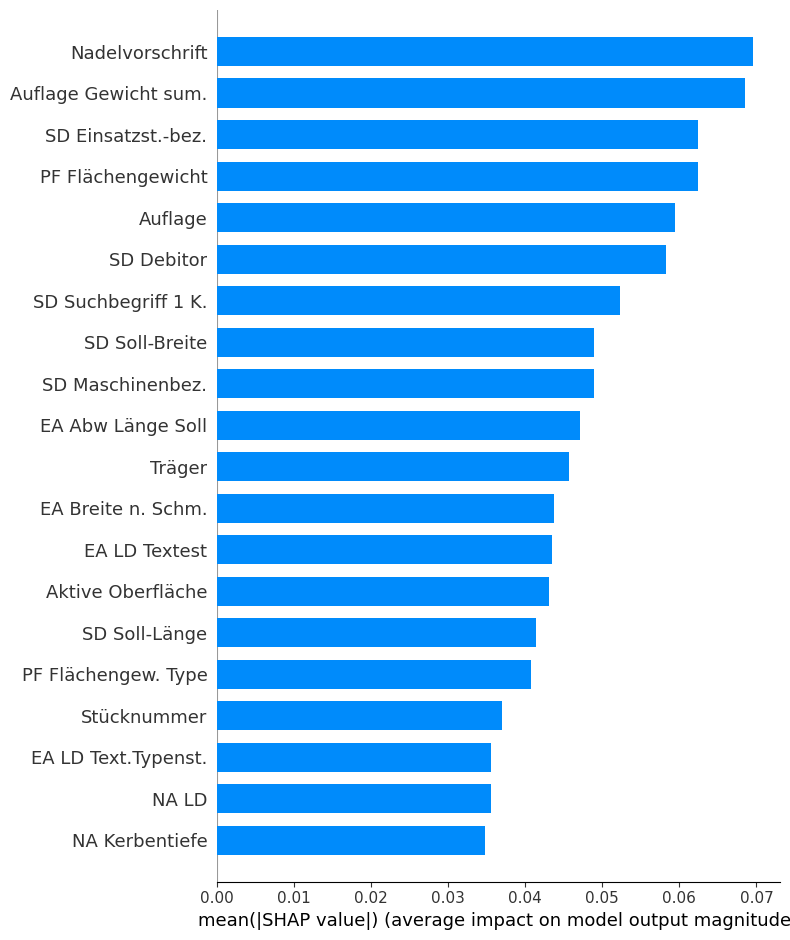

Shapley Values Berechnungszeit: 8.26


In [1]:
from src import database
from src.Dataset import Dataset
from src import plot

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

#Vorverarbeitete Daten aus CSV auslesen
df = pd.read_csv("data/df_preprocessed_all.csv", sep = ",")
df = df.drop(columns=['FELT_LIFE','REMOVAL_DATE', 'INSTALLATION_DATE', 'REPORT_DATE'])

# Überprüfen Sie die Existenz der ausgewählten Spalten im DataFrame, da beim Preprocessing Spalten entfernt wurden in df_preprocessed
heimbach_features = [col for col in database.get_heimbach_important_features() if col in df.columns]
df_heimbach= df[heimbach_features]

#Das Label nennen
label = df_heimbach.columns.get_loc('FELT_LIFE_NET')
header = df_heimbach.columns

#Machine Learning Algorithms die benutzt werden
MLA = [
    #('Linear Regressor',LinearRegression()),
    #('SVR', SVR()),
    #('Random Forest',RandomForestRegressor()),
    ('Gradient Boosting', xgb.XGBRegressor())
]

results = {}
predictions = {}

# Für alle Modelle in MLA Trainvalidierung, Cross-Validierung und Testvalidierung 
for model_name, model_instance in MLA:
    
    dataset = Dataset(df_heimbach, 'df', label, divide_dataset=False, header=header)
    dataset.divide_dataset(model_instance, normalize=False, shuffle=True, all_features=True, all_instances=True, evaluate=True, partial_sample=False,folds=5)
    
    selected_features = list(range(df_heimbach.shape[1]))
    num_selected_features = len(selected_features)
    
    #Regressor trainieren
    dataset.fit_classifier()
    dataset.shapley_values()
   